<a href="https://colab.research.google.com/github/ChikinH/DeepLearning/blob/main/CUB_200_2011_CNN_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries
To make it work, check PATH in this section.

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change it to your path to CUB_200_2011
PATH = Path('/content/drive/MyDrive/Colab Notebooks/DeepLearning/CUB_200_2011/')

In [ ]:
# Print README to check the PATH
with open(str(PATH)+'/README','r') as fin:
  print(fin.read())

The Caltech-UCSD Birds-200-2011 Dataset

For more information about the dataset, visit the project website:

  http://www.vision.caltech.edu/visipedia

If you use the dataset in a publication, please cite the dataset in
the style described on the dataset website (see url above).

Directory Information
---------------------

- images/
    The images organized in subdirectories based on species. See 
    IMAGES AND CLASS LABELS section below for more info.
- parts/
    15 part locations per image. See PART LOCATIONS section below 
    for more info.
- attributes/
    322 binary attribute labels from MTurk workers. See ATTRIBUTE LABELS 
    section below for more info.



IMAGES AND CLASS LABELS:
Images are contained in the directory images/, with 200 subdirectories (one for each bird species)

------- List of image files (images.txt) ------
The list of image file names is contained in the file images.txt, with each line corresponding to one image:

<image_id> <image_name>
---------------

# Pre-treatment
Use of YOLOv3 with pre-trained weigths to detect 5 parts of bird's body.  
Register the bounding boxes in a dataframe, saved as csv.  
Require to past **printf("class : %d, %d, %d, %d, %d\n", class,left, bot, right, top);** in **draw_detection()** (/darknet/src/image.c) just before **draw_box_width()**.


In [ ]:
!ls

drive  sample_data


Get YOLO config for bird's body parts.

In [ ]:
!git clone https://github.com/wuyun8210/partdetection.git

Cloning into 'partdetection'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Unpacking objects: 100% (20/20), done.


Get darknet YOLOv3.

In [ ]:
!git clone https://github.com/pjreddie/darknet.git
%cd darknet

In [ ]:
!make

gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/image.c -o obj/image.o
gcc -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -shared obj/gemm.o obj/utils.o obj/cuda.o obj/deconvolutional_layer.o obj/convolutional_layer.o obj/list.o obj/image.o obj/activations.o obj/im2col.o obj/col2im.o obj/blas.o obj/crop_layer.o obj/dropout_layer.o obj/maxpool_layer.o obj/softmax_layer.o obj/data.o obj/matrix.o obj/network.o obj/connected_layer.o obj/cost_layer.o obj/parser.o obj/option_list.o obj/detection_layer.o obj/route_layer.o obj/upsample_layer.o obj/box.o obj/normalization_layer.o obj/avgpool_layer.o obj/layer.o obj/local_layer.o obj/shortcut_layer.o obj/logistic_layer.o obj/activation_layer.o obj/rnn_layer.o obj/gru_layer.o obj/crnn_layer.o obj/demo.o obj/batchnorm_layer.o obj/region_layer.o obj/reorg_layer.o obj/tree.o obj/lstm_layer.o obj/l2norm_layer.o obj/yolo_layer.o obj/iseg_layer.o obj/image_opencv.o -o l

Test darknet on an image.

In [ ]:
!./darknet detect '/content/partdetection/yolov3_bird.cfg' '/content/drive/MyDrive/Colab Notebooks/DeepLearning/yolov3_bird_final.weights' '/content/drive/MyDrive/Colab Notebooks/DeepLearning/CUB_200_2011/images/016.Painted_Bunting/Painted_Bunting_0019_15231.jpg' -out results/result

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    8 res    5                 104 x 104 x 128   ->   104 x 104 x 128
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
   11 res    8                 104 x 

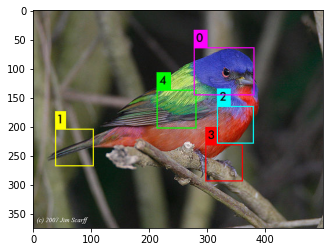

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/darknet/results/result.jpg')
imgplot = plt.imshow(img)
plt.show()

Crop to a specific bounding box.

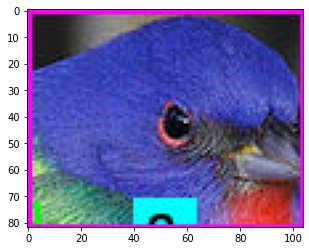

In [ ]:
imgcrop = crop(img, 64, 277, 146-64, 381-277)
imgplot = plt.imshow(imgcrop)
plt.show()

Use darknet on every image, and save all the bouding box in a csv file.  
This way takes a lot of time (about 16hours), could be changed.

In [ ]:
import os
cmd = "./darknet detect '/content/partdetection/yolov3_bird.cfg' '/content/drive/MyDrive/Colab Notebooks/DeepLearning/yolov3_bird_final.weights' "
boxes = pd.DataFrame(columns=['Image','class','left','bot','right','top'])
for index,image in images[7401:].iterrows():
  print(index)
  stream = os.popen(cmd+"'"+str(PATH/'images'/image['path'])+"'")
  while True:
    output = stream.readline()
    if output == '':
      break
    elif output[:5] == 'class':
      res = output[7:-1].split(',')
      boxes.loc[len(boxes.index)] = [image['id']] + res
  if index%100 == 0:
    boxes.to_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/bounding_boxes.csv')
boxes.to_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/bounding_boxes.csv')

In [ ]:
boxes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/bounding_boxes.csv')
boxes = boxes.drop(columns=['Unnamed: 0'])

In [ ]:
boxes.head()

,Image,class,left,bot,right,top
0,1,0,70,234,341,44
1,2,2,209,186,267,128
2,2,1,134,184,189,122
3,2,0,250,162,291,130
4,3,2,278,287,356,220


In [ ]:
boxes.tail()

,Image,class,left,bot,right,top
53378,11788,4,61,254,121,190
53379,11788,3,60,334,120,273
53380,11788,2,119,261,185,189
53381,11788,1,3,366,63,303
53382,11788,0,93,173,183,109


In [ ]:
boxes.describe()

,Image
count,53383.000000
mean,6006.951914
std,3388.112043
min,1.000000
25%,3136.500000
50%,6068.000000
75%,8939.500000
max,11788.000000


# Prepare datasets
Prepare class derived from Pytorch Dataset to feed CNNs.

In [ ]:
boxes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/bounding_boxes.csv')
boxes = boxes.drop(columns=['Unnamed: 0'])
boxes.columns = ['Image','Body part','left','bot','right','top']
boxes.head()

,Image,Body part,left,bot,right,top
0,1,0,70,234,341,44
1,2,2,209,186,267,128
2,2,1,134,184,189,122
3,2,0,250,162,291,130
4,3,2,278,287,356,220


## Few helper functions

**read_image()**  and convert it to RGB for matplotlib visualisation.

In [ ]:
def read_image(path):
  return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

Data augmentation functions.

In [ ]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [ ]:
def apply_transforms(x, sz=(224, 224), zoom=1.05):
    """ Applies a random crop, rotation"""
    sz1 = int(zoom*sz[0])
    sz2 = int(zoom*sz[1])
    x = cv2.resize(x, (sz1, sz2))
    x = rotate_cv(x, np.random.uniform(-10,10))
    x = random_crop(x, sz[1], sz[0])
    if np.random.rand() >= .5:
                x = np.fliplr(x).copy()
    return x

**show_image()** and **visualize()** display images from dataset.

In [ ]:
def show_image(img):
  plt.imshow(img)

In [ ]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im/255.0 - imagenet_stats[0])/imagenet_stats[1]

def denormalize(img):
  imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
  return img*imagenet_stats[1] + imagenet_stats[0]
  
def visualize(dataloader, categories):
    """Imshow for Tensor."""
    x,y = next(iter(dataloader))
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(8):
      inp = x[i]
      inp = inp.numpy().transpose(1,2,0)
      inp = denormalize(inp)
      
      ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
      plt.imshow(inp)
      plt.title(str(categories[y[i]]))

## Dataset informations

In [ ]:
labels = pd.read_csv(PATH/"image_class_labels.txt", header=None,sep=" ")
labels.columns = ["id","label"]
labels.head()

,id,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [ ]:
labels.describe()

,id,label
count,11788.000000,11788.000000
mean,5894.500000,101.126315
std,3403.046821,57.476826
min,1.000000,1.000000
25%,2947.750000,51.000000
50%,5894.500000,101.000000
75%,8841.250000,151.000000
max,11788.000000,200.000000


In [ ]:
train_test = pd.read_csv(PATH/"train_test_split.txt", header=None, sep=" ")
train_test.columns = ["id","is_train"]
train_test.head()

,id,is_train
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1


In [ ]:
images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")
images.columns = ["id", "name"]
images.head()

,id,name
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...


In [ ]:
classes = pd.read_csv(PATH/"classes.txt", header=None, sep=" ")
classes.columns = ["id", "class"]
classes.head()
categories = [x for x in classes["class"]]

## Custom dataset class

In [ ]:
class CUB(Dataset):
  def __init__(self, files_path, labels, train_test, image_name, train=True, transform=False, boxes=None):
    self.files_path = files_path
    self.labels = labels
    self.train_test = train_test
    self.image_name = image_name
    self.transform = transform
    self.boxes = boxes

    if train:
      mask = self.train_test.is_train.values == 1
    else:
      mask = self.train_test.is_train.values == 0

    self.filenames = self.image_name.iloc[mask]
    self.labels = self.labels[mask]

    if self.boxes is not None:
      self.boxes[mask[:len(self.boxes)]]
      self.filenames = self.filenames.loc[self.filenames['id'].isin(self.boxes['Image'].tolist())]
      self.labels = self.labels.loc[self.labels['id'].isin(self.boxes['Image'].tolist())]
    
    self.num_files = self.labels.shape[0]

  def __len__(self):
    return self.num_files

  def __getitem__(self, index):
    y = self.labels.iloc[index,1] - 1

    file_name = self.filenames.iloc[index, 1]
    path = self.files_path/'images'/file_name
    x = read_image(path)
    if self.boxes is not None:
      id = self.filenames.iloc[index,0]
      box = self.boxes.query('Image==@id')
      box = box.iloc[0]
      x = crop(x, box.top,box.left,box.bot-box.top,box.right-box.left)
    if self.transform:
            x = apply_transforms(x)
    else:
            x = cv2.resize(x, (224,224))
    x = normalize(x)
    x = np.rollaxis(x,2) # Need for Pytorch's input specification
    return x,y

## Full images dataset

In [ ]:
train_dataset = CUB(PATH, labels, train_test, images, train= True, transform=True)
valid_dataset = CUB(PATH, labels, train_test, images, train= False, transform=False)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=64, num_workers=4)

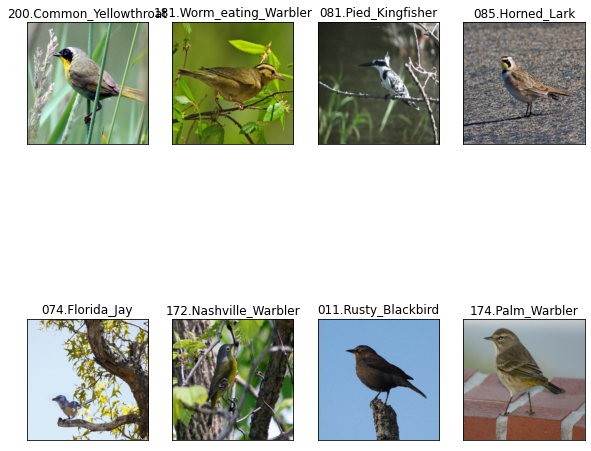

In [ ]:
visualize(train_loader, categories)

## Body part 0 dataset (Head)

In [ ]:
boxes0 = boxes.query('`Body part`==0')
boxes0 = boxes0.drop(columns=['Body part'])


In [ ]:
train0_dataset = CUB(PATH, labels, train_test, images, train= True, transform=True,boxes=boxes0)
valid0_dataset = CUB(PATH, labels, train_test, images, train= False, transform=False,boxes=boxes0)

In [ ]:
train0_loader = DataLoader(train0_dataset, batch_size=64, shuffle=True, num_workers=4)
valid0_loader = DataLoader(valid0_dataset, batch_size=64, num_workers=4)

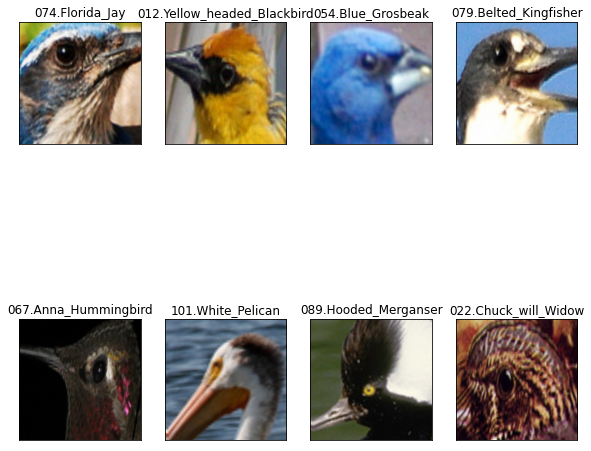

In [ ]:
visualize(train0_loader, categories)

# Training CNNs
Taining on full image dataset, and on head dataset.  
The others body's part haven't been trained since the code is similar, and the perfomance are lower than full image (check sources).

## Function used for each model
From source.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 200)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [ ]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [ ]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=1, beta=0.9):
  losses = []
  # Model save path
  p = PATH/"mode_tmp.pth"
  save_model(model, str(p))
  num = len(train_dl)-1
  mult = (lr_high / lr_low) ** (1.0/num)
  lr = lr_low
  avg_loss = 0.
  best_loss = 0.
  batch_num = 0
  log_lrs = []

  model.train()
  for i in range(epochs):
    for x,y in train_dl:
      batch_num +=1
      optim = get_optimizer(model, lr=lr)
      x = x.cuda().float()
      y = y.cuda().long()   
      out = model(x)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(out, y)

      #Compute the smoothed loss
      avg_loss = beta * avg_loss + (1-beta) *loss.item()
      smoothed_loss = avg_loss / (1 - beta**batch_num)

      #Stop if the loss is exploding
      if batch_num > 1 and smoothed_loss > 4 * best_loss:
        return log_lrs, losses

      #Record the best loss
      if smoothed_loss < best_loss or batch_num==1:
        best_loss = smoothed_loss
      #Store the values
      losses.append(smoothed_loss)
      log_lrs.append(math.log10(lr))

      optim.zero_grad()
      loss.backward()
      optim.step()
      #Update the lr for the next step
      lr *= mult
  load_model(model, str(p))
  return log_lrs, losses

In [ ]:
def get_triangular_lr(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [ ]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, 
                            lr_high=0.01, epochs = 4):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_triangular_lr(lr_low, lr_high, iterations)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().long()
            out = model(x)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total

In [ ]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().long()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y.data).sum().item()
        y = y.long()
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss and accuracy", sum_loss/total, correct/total)

In [ ]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-6, lr_high=0.01, epochs = 4):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high, epochs)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

## Training on full image

In [ ]:
model = Net().cuda()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-6, lr_high=0.1)

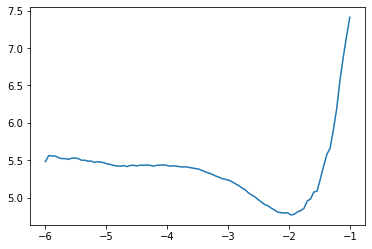

In [ ]:
plt.plot(lrs, losses)
plt.show()

In [ ]:
val_metrics(model, valid_loader)

val loss and accuracy 5.343690623157305 0.0069036934760096655


In [ ]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1e-3, lr_high=1*1e-2, epochs = 16)

train loss 4.7229715760326165
val loss and accuracy 4.5882151634642945 0.17518122195374525
train loss 4.573891504788581
val loss and accuracy 4.448399985704827 0.16655160510873318
train loss 4.337556028031969
val loss and accuracy 4.266885737694664 0.17915084570245082
train loss 4.080576516406951
val loss and accuracy 4.095241941334175 0.20262340352088368
train loss 3.9255378328246358
val loss and accuracy 4.041891789493949 0.21539523645150155
train loss 3.7736959070772738
val loss and accuracy 3.9249776471348357 0.23041076976182256
train loss 3.435103245405185
val loss and accuracy 3.6877556541766796 0.26717293752157406
train loss 3.1665370746736015
val loss and accuracy 3.519108571140446 0.3151536071798412
train loss 3.030456220383719
val loss and accuracy 3.4261835185173752 0.3474283741801864
train loss 2.9910842323048654
val loss and accuracy 3.420257257271274 0.3759061097687263
train loss 3.008514597529684
val loss and accuracy 3.514837363278985 0.4043838453572661
train loss 3.127

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DeepLearning/fullcnn.pth')

In [ ]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [ ]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [ ]:
unfreeze(model, 7)
unfreeze(model, 6)
unfreeze(model, 5)

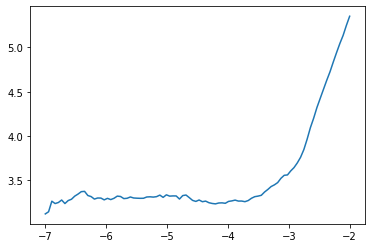

In [ ]:
#New
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-7, lr_high=0.01)
plt.plot(lrs, losses)
plt.show()

In [ ]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1e-5, lr_high=1*1e-4, epochs = 30)

train loss 3.250212114255827
val loss and accuracy 3.554667709694264 0.4884363134276838
train loss 3.0979852567404795
val loss and accuracy 3.396225828773859 0.5279599585778392
train loss 2.970286862628238
val loss and accuracy 3.33620424315071 0.5626510182947877
train loss 2.838149216877527
val loss and accuracy 3.2211613747264582 0.5730065585088022
train loss 2.6893871568782273
val loss and accuracy 3.1565890113855586 0.6083879875733518
train loss 2.539644046190941
val loss and accuracy 3.041746642863623 0.6280635139799793
train loss 2.3754888558570726
val loss and accuracy 2.9772993275573594 0.6473938557128064
train loss 2.2041197203380647
val loss and accuracy 2.8363721042326246 0.6632723507076286
train loss 2.0112544669681762
val loss and accuracy 2.7450708884142743 0.67138419054194
train loss 1.8125825553963413
val loss and accuracy 2.6117050887635544 0.6895063859164653
train loss 1.5728871074564503
val loss and accuracy 2.3939728001540885 0.7079737659647911
train loss 1.31343040

In [ ]:
unfreeze(model, 4)
unfreeze(model, 3)
unfreeze(model,2)

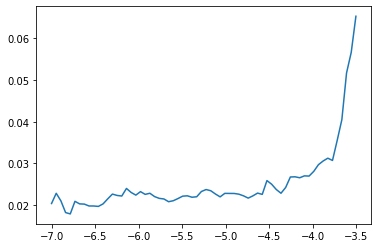

In [ ]:
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-7, lr_high=0.01)
plt.plot(lrs, losses)
plt.show()

In [ ]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1e-7, lr_high=1*1e-5, epochs = 10)

train loss 0.23121161458589334
val loss and accuracy 1.5795384277176518 0.6981360027614774
train loss 0.08230231307175981
val loss and accuracy 1.3814388738034058 0.7329996548153263
train loss 0.042111673589682715
val loss and accuracy 1.3043099270633964 0.7480151881256473
train loss 0.02906509117162104
val loss and accuracy 1.2809253999558983 0.7523299965481532
train loss 0.022493572341956255
val loss and accuracy 1.2523518461665903 0.7550914739385571
train loss 0.02016762123481409
val loss and accuracy 1.2378667514201565 0.7566448049706593
train loss 0.019110652023020848
val loss and accuracy 1.2399091846703414 0.7562996202968588
train loss 0.019091115862349888
val loss and accuracy 1.2395209992059477 0.7561270279599586
train loss 0.018586189999448027
val loss and accuracy 1.2386227998397743 0.757852951328961
train loss 0.01871144524404097
val loss and accuracy 1.225401329076574 0.7568173973075596
----End of step Time elapsed 0:16:08.312816


In [ ]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1e-7, lr_high=5*1e-7, epochs = 10)

train loss 0.018282611712360924
val loss and accuracy 1.221678406195596 0.757852951328961
train loss 0.017283727002227887
val loss and accuracy 1.2307293796728593 0.7538833275802554
train loss 0.017408534092657718
val loss and accuracy 1.2275880161013157 0.7564722126337591
train loss 0.01711220400016985
val loss and accuracy 1.2279908274180484 0.7544011045909561
train loss 0.01704398523251693
val loss and accuracy 1.2228802616611858 0.7559544356230583
train loss 0.017260305760605436
val loss and accuracy 1.2295981011680377 0.7552640662754574
train loss 0.016879065028147216
val loss and accuracy 1.2227104810504696 0.7559544356230583
train loss 0.017436547967436555
val loss and accuracy 1.2284388534151196 0.7535381429064549
train loss 0.017189010630946258
val loss and accuracy 1.229909845640382 0.7552640662754574
train loss 0.016996766587555865
val loss and accuracy 1.224831608356506 0.7564722126337591
----End of step Time elapsed 0:16:11.097518


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DeepLearning/fullcnn.pth')

## Training on body part 0

In [ ]:
model0 = Net().cuda()

In [ ]:
lrs, losses = LR_range_finder(model0, train0_loader, lr_low=1e-6, lr_high=0.1)

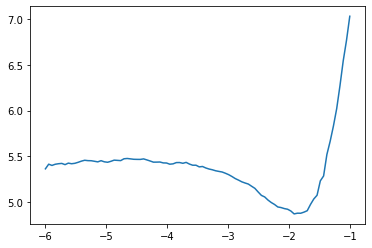

In [ ]:
plt.plot(lrs, losses)
plt.show()

In [ ]:
val_metrics(model0, valid0_loader)

val loss and accuracy 5.3484424692477 0.00398337374437132


In [ ]:
training_loop(model0, train0_loader, valid0_loader, steps=1, lr_low= 1e-3, lr_high=1*1e-2, epochs = 16)

train loss 4.8425333010270295
val loss and accuracy 4.777189682378132 0.157776238309664
train loss 4.723551508884302
val loss and accuracy 4.672480035331946 0.1499826809837201
train loss 4.51276865837558
val loss and accuracy 4.436498704400903 0.157083477658469
train loss 4.295346396401425
val loss and accuracy 4.342953306025686 0.16175961205403533
train loss 4.212022908101946
val loss and accuracy 4.351333107798001 0.17925181849670938
train loss 4.089492246128569
val loss and accuracy 4.122569974500249 0.19518531347419465
train loss 3.762086159750919
val loss and accuracy 3.990333829158972 0.22306892968479392
train loss 3.6268492071420555
val loss and accuracy 3.8478101352774896 0.2478351229650156
train loss 3.54233388132697
val loss and accuracy 3.8353901572569375 0.28680290959473503
train loss 3.524922415714136
val loss and accuracy 3.8300766730993976 0.3266366470384482
train loss 3.597519027146717
val loss and accuracy 3.929367913810035 0.33945271908555597
train loss 3.718754047675

In [ ]:
unfreeze(model, 7)
unfreeze(model, 6)
unfreeze(model, 5)

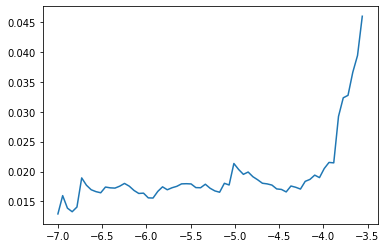

In [ ]:
#New
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-7, lr_high=0.01)
plt.plot(lrs, losses)
plt.show()

In [ ]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1e-5, lr_high=1*1e-4, epochs = 30)

train loss 0.05429999569407952
val loss and accuracy 1.2751913675572242 0.7443907490507421
train loss 0.020212785937177923
val loss and accuracy 1.3277419190963138 0.749223334483949
train loss 0.016180993725281877
val loss and accuracy 1.2640248798361144 0.752157404211253
train loss 0.0142777665907596
val loss and accuracy 1.3765747891568627 0.7386952019330342
train loss 0.014269995598839071
val loss and accuracy 1.5415654961183065 0.7298929927511218
train loss 0.018360123059733793
val loss and accuracy 1.523877916889105 0.7312737314463238
train loss 0.01852313341112347
val loss and accuracy 1.583859789400295 0.7229892992751122
train loss 0.01988626291498686
val loss and accuracy 1.5233038462438706 0.7096996893337936
train loss 0.020405941652454136
val loss and accuracy 1.315037975856095 0.7250604073179151
train loss 0.01861790114436342
val loss and accuracy 1.4463332043790307 0.7026234035208837
train loss 0.0233998102706807
val loss and accuracy 1.3631594127155313 0.7226441146013117
t

In [ ]:
unfreeze(model, 4)
unfreeze(model, 3)
unfreeze(model,2)

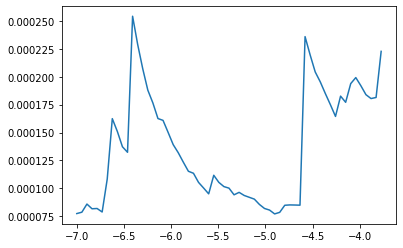

In [ ]:
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-7, lr_high=0.01)
plt.plot(lrs, losses)
plt.show()

In [ ]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1e-7, lr_high=1*1e-5, epochs = 10)

train loss 0.0026067429618705012
val loss and accuracy 1.2245388165152316 0.7495685191577494
train loss 0.00028587325118230945
val loss and accuracy 1.1749738608716807 0.755781843286158
train loss 0.00030953075249774475
val loss and accuracy 1.1477857983272817 0.7613047980669658
train loss 0.0001054131377847759
val loss and accuracy 1.1495632715150328 0.7632033137728684
train loss 8.604077117983407e-05
val loss and accuracy 1.1413632229376875 0.7635484984466689
train loss 8.849341233372723e-05
val loss and accuracy 1.1445380428308942 0.7632033137728684
train loss 7.003971347940937e-05
val loss and accuracy 1.142378195929947 0.7647566448049706
train loss 5.557071686176037e-05
val loss and accuracy 1.1474673885146132 0.7614773904038661
train loss 6.479624737472304e-05
val loss and accuracy 1.1391892270627086 0.7651018294787711
train loss 6.009954677681147e-05
val loss and accuracy 1.1402699860223704 0.7637210907835692
----End of step Time elapsed 0:16:47.654953


In [ ]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1e-7, lr_high=5*1e-7, epochs = 10)

train loss 5.758213885737183e-05
val loss and accuracy 1.1445119557995445 0.7638936831204695
train loss 6.717737387440596e-05
val loss and accuracy 1.140697578602838 0.7654470141525717
train loss 5.944635377078751e-05
val loss and accuracy 1.1422968778295026 0.7632033137728684
train loss 5.620156454252875e-05
val loss and accuracy 1.1449593924060542 0.7630307214359683
train loss 6.002285142956596e-05
val loss and accuracy 1.1433916670374102 0.7640662754573697
train loss 5.225371201834177e-05
val loss and accuracy 1.1445250381035026 0.7618225750776666
train loss 6.048290345852453e-05
val loss and accuracy 1.142722626678031 0.7645840524680704
train loss 7.545581211052086e-05
val loss and accuracy 1.1449672433582716 0.7635484984466689
train loss 5.342287062932226e-05
val loss and accuracy 1.144860234740359 0.7647566448049706
train loss 5.720839603416545e-05
val loss and accuracy 1.14616388808788 0.7638936831204695
----End of step Time elapsed 0:16:50.752961


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DeepLearning/0cnn.pth')

# Loading trained models

In [ ]:
model = Net().cuda()
load_model(model, '/content/drive/MyDrive/Colab Notebooks/DeepLearning/fullcnn.pth')

model0 = Net().cuda()
load_model(model0, '/content/drive/MyDrive/Colab Notebooks/DeepLearning/0cnn.pth')

# Accuracy Metrics

## Function used for each model

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def calc_accuracy(model, dataloader):
    model.eval()
    model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        
        inputs, labels = inputs.cuda().float(), labels.cuda().long()
        # obtain the outputs from the model
        outputs = model.forward(inputs)
        prec1, prec5 = accuracy(outputs, labels, topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5
    

## Full image model

In [ ]:
top1 ,top5 = calc_accuracy(model, valid_loader)

In [ ]:
top1.avg

tensor(75.6472, device='cuda:0')

In [ ]:
top5.avg

tensor(92.2679, device='cuda:0')

## Body part 0 only model

In [ ]:
top1 ,top5 = calc_accuracy(model0, valid0_loader)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd3b72b4860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd3b7618320>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

In [ ]:
top1.avg

tensor(38.9678, device='cuda:0')

In [ ]:
top5.avg

tensor(60.7205, device='cuda:0')

# Sources
Research paper on CUB classification : https://arxiv.org/pdf/1808.03935.pdf  
Colab where parts of the code come from : https://colab.research.google.com/drive/1KzGRSNQpP4BonRKj3ZwGMTGdi-e2y8z-?authuser=1#scrollTo=Bj_riya9wjJI  
YOLO source : https://pjreddie.com/darknet/yolo/